## Contents:
0. [Preparation](#preparation)
1. [Model Selection](#Model-Selection)
   - [Linear models](#Linear_models)
   - [XGBoost](#XGBoost)
   - [Support Vector Regression](#SVR)
   - [Comparison of performance](#performance)
2. [Feature Importance](#Feature-Importance)

<a id='preparation'></a>
## Preparation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from prepare import generate_polynomial


fname = 'train.csv'
data = pd.read_csv('data/preprocessed_' + fname, index_col='Id')
n_examples, n_features = data.shape
X, y = data.drop(columns=['log_SalePrice']), data['log_SalePrice']
print(X.isna().sum().sum())

# adding polynomial terms
X = generate_polynomial(X)
print(X.isna().sum().sort_values(ascending=False).head())

# standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
index, features = X.index, X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, index=index, columns=features)
print(X.isna().sum().sum())

# train/test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


## Model Selection

In [2]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error"))
    return rmse

def print_err(models):
    for model in models:
        print("RMSE for {:15s}: {:5.3f}".format(model.__class__.__name__, rmse_cv(model).mean()))


<a id='Linear_models'></a>

### Linear models

In [3]:
max_iter = 1000
alpha_range = np.arange(0.01, 0.15, 0.01)

ridge = RidgeCV(alphas = alpha_range, 
                scoring="neg_mean_squared_error").fit(X_train, y_train)
lasso = LassoCV(alphas = alpha_range).fit(X_train, y_train)
elastic_net = ElasticNetCV(alphas=alpha_range).fit(X_train, y_train)

print_err([ridge, lasso, elastic_net])

RMSE for RidgeCV        : 0.120
RMSE for LassoCV        : 0.123
RMSE for ElasticNetCV   : 0.121


<a id='XGBoost'></a>
### XGBoost

In [5]:
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

def hyperParameterTuning():
    param_grid = {
        "learning_rate" : [0.01, 0.1, 0.2, 0.3],
        "max_depth": [2, 3, 5],
        "min_child_weight": [1, 3, 5],
        "subsample" : [1],
        'colsample_bytree': [0.5],
        "n_estimators" : [200, 500],
        "objective": ['reg:squarederror'],  
    }
    
    gsearch = GridSearchCV(estimator=XGBRegressor(),
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          n_jobs=-1,
                          verbose=1)
    gsearch.fit(X, y)
    return gsearch.best_params_

# WARNING! It may take a few minutes.
# hyperParameterTuning()

RMSE for final XGBoost regressor:  0.12311356887518159


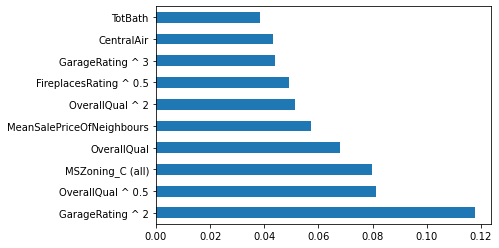

In [13]:
params = {'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'subsample': 1}

print("RMSE for final XGBoost regressor: ", rmse_cv(xgbr).mean())
xgbr = XGBRegressor(**params)
# xgbr.set_params(learning_rate=0.3)
xgbr.fit(X_train, y_train, verbose=0)


<a id='SVR'></a>

### Support Vector Regression

In [7]:
# hyperparameter tuning
from sklearn.svm import SVR

params = {
    "kernel": ["linear", "rbf"],
    "C": [0.5, 1, 2, 3],
    "epsilon": [0.01, 0.05, 0.1, 0.15, 0.2],
    "max_iter": [2000],
    "gamma": [0.001, 0.01, 0.1, 1, 10]}

# # WARNING! Grid search may take a few minutes.
# gsearch = GridSearchCV(estimator= SVR(),
#                        param_grid=params,
#                        scoring='neg_mean_squared_error',
#                        cv=5,
#                        n_jobs=-1,
#                        verbose=1)
# gsearch.fit(X, y)
# gsearch.best_params_

params = {'C': 1, 'epsilon': 0.05, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': 5000}
svr = SVR(**params)

<a id='performance'></a>
### Comparison of model performances

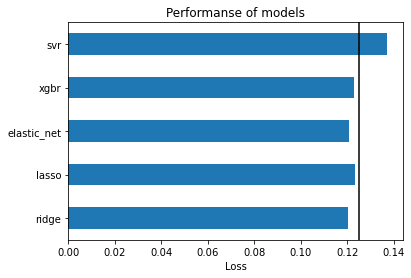

In [19]:
err = pd.Series(index=["ridge", "lasso", "elastic_net", "xgbr", "svr"], dtype="float64")
for i, model in enumerate([ridge, lasso, elastic_net, xgbr, svr]):
    err.iloc[i] = rmse_cv(model).mean()
    
err.plot(kind="barh")
plt.axvline(err.mean(), color='black')
plt.title('Performanse of models')
plt.xlabel('Loss');


    
## Feature Importance

# of important features:  21


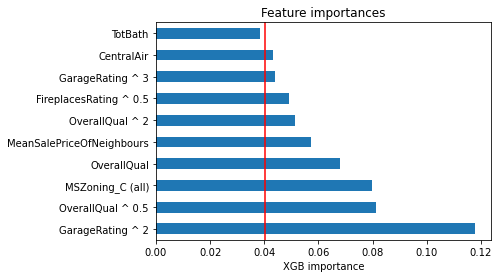

In [37]:
imp= pd.Series(xgbr.feature_importances_, index=features)
imp = imp[imp > 0.01]
print('# of important features: ', len(imp))
imp = imp.sort_values(ascending=False)

imp.head(10).plot(kind='barh')
plt.axvline(imp.mean(), color='red', label='mean')
plt.xlabel('XGB importance')
plt.title('Feature importances');